# <center>DataLab Cup 2: CNN Object Detection</center>

<center>111062201 林威盛<br/>111062209 毛柏毅<br/>111062315 張以寧</center>


### Overview

In this competition, you have to train a model that recognizes objects in an image. Your goal is to output bounding boxes for objects. Given an image (shape = [undefined, undefined, 3]), you need to output bounding box ($x_{\min}$, $y_{\min}$, $x_{\max}$, $y_{\max}$, `class_label`, `confidence_score`) for objects shown in image and its class.

#### [Kaggle Competition](https://www.kaggle.com/competitions/2024-datalab-cup2)

#### [Notebook](https://nthu-datalab.github.io/ml/competitions/Comp_02_Object-Detection/02_Object_Detection.html)


## Configurations


In [ ]:
from typing import Literal


# constants
IMAGE_SIZE = 448
NUM_CLASSES = 20
MAX_OBJECTS_PER_IMAGE = 20

# dataset constants
DATA_FOLDER = './data/2024'
TRAIN_DATA_PATH = 'pascal_voc_training_data.txt'
TEST_DATA_PATH = 'pascal_voc_testing_data.txt'
TRAIN_IMG_DIR = 'VOCdevkit_train/VOC2007/JPEGImages/'
TEST_IMG_DIR = 'VOCdevkit_test/VOC2007/JPEGImages/'
AUG_DATA_PATH = 'pascal_voc_aug_data.txt'
AUG_IMG_DIR = 'aug_data/'
AUGMENT_DATA = False
AUGMENT_SCALE = 10

# model params
FEATURE_EXTRACTOR: Literal['yolo', 'resnet_v2', 'densenet', 'vgg19', 'efficientnet_v2'] = 'efficientnet_v2'
FE_FIXED = True
CELL_SIZE = 5
BOXES_PER_CELL = 4
OBJECT_SCALE = 1  # object loss weight
NOOBJECT_SCALE = 0.5  # noobject loss weight
CLASS_SCALE = 1  # class loss weight
COORD_SCALE = 5  # coord loss weight

# training params
BATCH_SIZE = 32
LEARNING_RATE = 3e-5
EPOCHS = 60

# prediction params
CONFIDENCE_THRESHOLD = 0.001
MIN_PREDICTION_NUM = 1

In [2]:
import tensorflow as tf

2024-11-19 08:31:31.621157: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-19 08:31:31.745491: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
import albumentations as A
import numpy as np

/home/sysadmin/miniconda3/envs/tfenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Select GPU number 1
        tf.config.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

4 Physical GPUs, 1 Logical GPUs


2024-11-19 08:31:35.980140: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-19 08:31:36.128383: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31132 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0


## Data Preprocessing


### Load Data


In [5]:
classes_name = [
    "aeroplane", "bicycle", "bird", "boat", "bottle",
    "bus", "car", "cat", "chair", "cow", "diningtable",
    "dog", "horse", "motorbike", "person", "pottedplant",
    "sheep", "sofa", "train", "tvmonitor"]

The data format of pascal_voc_training_data is:

$\text{image\_name}$ [$\text{xmin}_i$ $\text{ymin}_i$ $\text{xmax}_i$ $\text{ymax}_i$ $\text{class}_i$ ] (repeat number of objects times)

Elements are separated by space.


In [6]:
import os


training_data_file = open(os.path.join(DATA_FOLDER, "pascal_voc_training_data.txt"), "r")
for i, line in enumerate(training_data_file):
    if i > 5:
        break
    line = line.strip()
    print(line)

000005.jpg 263 211 324 339 8 165 264 253 372 8 5 244 67 374 8 241 194 295 299 8 277 186 312 220 8
000007.jpg 141 50 500 330 6
000009.jpg 69 172 270 330 12 150 141 229 284 14 285 201 327 331 14 258 198 297 329 14
000012.jpg 156 97 351 270 6
000016.jpg 92 72 305 473 1
000017.jpg 185 62 279 199 14 90 78 403 336 12


### Data Augmentation

In [7]:
import os
import cv2
from tqdm import tqdm

In [8]:
def data_aug_gen():
    if not os.path.exists(os.path.join(DATA_FOLDER, AUG_IMG_DIR)):
        os.makedirs(os.path.join(DATA_FOLDER, AUG_IMG_DIR))
    with open(os.path.join(DATA_FOLDER, TRAIN_DATA_PATH), "rb") as training_data_file:
        num_lines = sum(1 for _ in training_data_file)
    augmented_data_file = open(os.path.join(DATA_FOLDER, AUG_DATA_PATH), "w")
    training_data_file = open(os.path.join(DATA_FOLDER, TRAIN_DATA_PATH), "r")
    for line in tqdm(training_data_file, total=num_lines):
        augmented_data_file.write(line)
        line = line.strip().split(" ")
        img_path = line[0]
        img = tf.io.read_file(os.path.join(DATA_FOLDER, TRAIN_IMG_DIR, img_path))
        img = tf.image.decode_jpeg(img, channels=3)
        img = img.numpy()
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        cv2.imwrite(os.path.join(DATA_FOLDER, AUG_IMG_DIR, img_path), img)
        bboxes = []
        class_labels = []
        for i in range(1, len(line), 5):
            bboxes.append([int(x) for x in line[i:i+4]])
            class_labels.append(int(line[i+4]))

        aug = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.RandomGamma(p=0.5),
            A.ShiftScaleRotate(p=0.5),
            A.RandomBrightnessContrast(p=0.3),
            A.RGBShift(r_shift_limit=30, g_shift_limit=30, b_shift_limit=30, p=0.3),
            A.RandomSizedBBoxSafeCrop(IMAGE_SIZE, IMAGE_SIZE, p=0.5),
            A.Resize(IMAGE_SIZE, IMAGE_SIZE)
        ], bbox_params=A.BboxParams(format="pascal_voc", min_area=2000, min_visibility=0.2, label_fields=["class_labels"]))
        
        for i in range(1, AUGMENT_SCALE):
            augmented = aug(image=img, bboxes=bboxes, class_labels=class_labels)
            augmented_img = augmented["image"]
            augmented_bboxes = augmented["bboxes"]
            augmented_class_labels = augmented["class_labels"]
            augmented_img_path = f"augmented_{i}" + img_path
            augmented_data_file.write(augmented_img_path)
            for j, bbox in enumerate(augmented_bboxes):
                bbox = np.array(bbox)
                bbox = bbox.astype(np.int32)
                augmented_data_file.write(" " + " ".join([str(x) for x in bbox]))
                augmented_data_file.write(" " + str(int(augmented_class_labels[j])))
            augmented_data_file.write("\n")
            cv2.imwrite(os.path.join(DATA_FOLDER, AUG_IMG_DIR, augmented_img_path), augmented_img)
    training_data_file.close()
    augmented_data_file.close()

In [9]:
if AUGMENT_DATA:
    data_aug_gen()

### Dataset Loader


In [11]:
import numpy as np
import keras

@tf.function
def image_preprocess(image: tf.Tensor):
    """
    Preprocess the image
    - Resize the image to IMAGE_SIZE x IMAGE_SIZE
    - Normalize the image to [-1, 1]

    Parameters
    ----------
    image : tf.Tensor
        Tensor with shape (h, w, 3), representing the image

    Returns
    -------
    image : tf.Tensor
        Tensor with shape (IMAGE_SIZE, IMAGE_SIZE, 3), representing the image
    """
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    if FEATURE_EXTRACTOR == 'yolo':
        image = (image / 255) * 2 - 1
    elif FEATURE_EXTRACTOR == 'resnet_v2':
        image = keras.applications.resnet_v2.preprocess_input(image)
    elif FEATURE_EXTRACTOR == 'densenet':
        image = keras.applications.densenet.preprocess_input(image)
    elif FEATURE_EXTRACTOR == 'vgg19':
        image = keras.applications.vgg19.preprocess_input(image)
    elif FEATURE_EXTRACTOR == 'efficientnet_v2':
        image = keras.applications.efficientnet_v2.preprocess_input(image)
    else:
        raise ValueError('Invalid FEATURE_EXTRACTOR')

    return image

class DatasetGenerator:
    """
    Load pascalVOC 2007 dataset and creates an input pipeline.
    - Reshapes images into 448 x 448
    - converts [0 1] to [-1 1]
    - shuffles the input
    - builds batches
    """

    def __init__(self):
        self.image_names = []
        self.record_list = []
        self.object_num_list = []
        # filling the record_list
        self.image_dir = os.path.join(DATA_FOLDER, AUG_IMG_DIR)

        input_file = open(os.path.join(DATA_FOLDER, AUG_DATA_PATH), 'r')

        for line in input_file:
            line = line.strip()
            ss = line.split(' ')
            self.image_names.append(ss[0])

            self.record_list.append([float(num) for num in ss[1:]])

            self.object_num_list.append(min(
                len(self.record_list[-1])//5,
                MAX_OBJECTS_PER_IMAGE))
            if len(self.record_list[-1]) < MAX_OBJECTS_PER_IMAGE*5:
                # if there are objects less than MAX_OBJECTS_PER_IMAGE, pad the list
                self.record_list[-1] = (
                    self.record_list[-1] +
                    [0., 0., 0., 0., 0.]*
                    (MAX_OBJECTS_PER_IMAGE - len(self.record_list[-1])//5))
            elif len(self.record_list[-1]) > MAX_OBJECTS_PER_IMAGE*5:
               # if there are objects more than MAX_OBJECTS_PER_IMAGE, crop the list
                self.record_list[-1] = self.record_list[-1][:MAX_OBJECTS_PER_IMAGE*5]
        
        input_file.close()
        
    def __len__(self):
        return len(self.image_names)

    @tf.function
    def _data_preprocess(self, image_name: tf.Tensor, raw_labels: tf.Tensor, object_num: tf.Tensor):
        """Preprocess the data

        Parameters
        ----------
        image_name : tf.Tensor
            Tensor with single string value, representing the image name
        raw_labels : tf.Tensor
            Tensor with type tf.float64 and shape (MAX_OBJECTS_PER_IMAGE*5,), representing the labels
        object_num : tf.Tensor
            Tensor with single integer value, representing the number of objects in the image

        Returns
        -------
        image : tf.Tensor
            Tensor with shape (448, 448, 3), representing the image
        labels : tf.Tensor
            Tensor with shape (MAX_OBJECTS_PER_IMAGE, 5), representing the labels
        object_num : tf.Tensor
            Tensor with single integer value, representing the number of objects in the image
        """
        image_file = tf.io.read_file(self.image_dir + image_name)
        image = tf.io.decode_jpeg(image_file, channels=3)

        h = tf.shape(image)[0]
        w = tf.shape(image)[1]

        width_ratio  = IMAGE_SIZE * 1.0 / tf.cast(w, tf.float32) 
        height_ratio = IMAGE_SIZE * 1.0 / tf.cast(h, tf.float32) 

        image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = image_preprocess(image)

        raw_labels = tf.cast(tf.reshape(raw_labels, [-1, 5]), tf.float32)

        xmin = raw_labels[:, 0]
        ymin = raw_labels[:, 1]
        xmax = raw_labels[:, 2]
        ymax = raw_labels[:, 3]
        class_num = raw_labels[:, 4]

        xcenter = (xmin + xmax) * 1.0 / 2.0 * width_ratio
        ycenter = (ymin + ymax) * 1.0 / 2.0 * height_ratio

        box_w = (xmax - xmin) * width_ratio
        box_h = (ymax - ymin) * height_ratio

        labels = tf.stack([xcenter, ycenter, box_w, box_h, class_num], axis=1)

        return image, labels, tf.cast(object_num, tf.int32)

    def generate(self):
        dataset = (
            tf.data.Dataset.from_tensor_slices(
                (self.image_names, 
                np.array(self.record_list),
                np.array(self.object_num_list)))
            .shuffle(100000)
            .map(self._data_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
            .batch(BATCH_SIZE, drop_remainder=True)
            .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        )

        return dataset

## Model


### Helper Functions

In [12]:
@tf.function
def iou(boxes1, boxes2):
    '''calculate ious
    Args:
      boxes1: 4-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4]  ====> (x_center, y_center, w, h)
      boxes2: 1-D tensor [4] ===> (x_center, y_center, w, h)

    Return:
      iou: 3-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
      ====> iou score for each cell
    '''

    # boxes1 : [4(xmin, ymin, xmax, ymax), cell_size, cell_size, boxes_per_cell]
    boxes1 = tf.stack([boxes1[:, :, :, 0] - boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] - boxes1[:, :, :, 3] / 2,
                      boxes1[:, :, :, 0] + boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] + boxes1[:, :, :, 3] / 2])

    # boxes1 : [cell_size, cell_size, boxes_per_cell, 4(xmin, ymin, xmax, ymax)]
    boxes1 = tf.transpose(boxes1, [1, 2, 3, 0])

    boxes2 = tf.stack([boxes2[0] - boxes2[2] / 2, boxes2[1] - boxes2[3] / 2,
                       boxes2[0] + boxes2[2] / 2, boxes2[1] + boxes2[3] / 2])

    # calculate the left up point of boxes' overlap area
    lu = tf.maximum(boxes1[:, :, :, 0:2], boxes2[0:2])
    # calculate the right down point of boxes overlap area
    rd = tf.minimum(boxes1[:, :, :, 2:], boxes2[2:])

    # intersection
    intersection = rd - lu

    # the size of the intersection area
    inter_square = intersection[:, :, :, 0] * intersection[:, :, :, 1]

    mask = tf.cast(intersection[:, :, :, 0] > 0, tf.float32) * tf.cast(intersection[:, :, :, 1] > 0, tf.float32)

    # if intersection is negative, then the boxes don't overlap
    inter_square = mask * inter_square

    # calculate the boxs1 square and boxs2 square
    square1 = (boxes1[:, :, :, 2] - boxes1[:, :, :, 0]) * (boxes1[:, :, :, 3] - boxes1[:, :, :, 1])
    square2 = (boxes2[2] - boxes2[0]) * (boxes2[3] - boxes2[1])

    return inter_square / (square1 + square2 - inter_square + 1e-6)

In [13]:
base_boxes = np.zeros([CELL_SIZE, CELL_SIZE, 4])

# initializtion for each cell
for y in range(CELL_SIZE):
    for x in range(CELL_SIZE):
        base_boxes[y, x, :] = [
            IMAGE_SIZE / CELL_SIZE * x, 
            IMAGE_SIZE / CELL_SIZE * y,
            0,
            0]

base_boxes = np.resize(base_boxes, [CELL_SIZE, CELL_SIZE, 1, 4])
base_boxes = np.tile(base_boxes, [1, 1, BOXES_PER_CELL, 1])

In [14]:
@tf.function
def losses_calculation(predict: tf.Tensor, label: tf.Tensor) -> tf.Tensor:
    """
    calculate loss
    Args:
    predict: 3-D tensor [cell_size, cell_size, num_classes + 5 * boxes_per_cell]
    label : [1, 5]  (x_center, y_center, w, h, class)
    """
    label = tf.reshape(label, [-1])

    # Step A. calculate objects tensor [CELL_SIZE, CELL_SIZE]
    # turn pixel position into cell position (corner)
    min_x = (label[0] - label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_x = (label[0] + label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_y = (label[1] - label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_y = (label[1] + label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_x = tf.floor(min_x)
    min_y = tf.floor(min_y)

    max_x = tf.minimum(tf.math.ceil(max_x), CELL_SIZE)
    max_y = tf.minimum(tf.math.ceil(max_y), CELL_SIZE)
    
    #calculate mask of object with cells
    onset = tf.cast(tf.stack([max_y - min_y, max_x - min_x]), dtype=tf.int32)
    object_mask = tf.ones(onset, tf.float32)

    offset = tf.cast(tf.stack([min_y, CELL_SIZE - max_y, min_x, CELL_SIZE - max_x]), tf.int32)
    offset = tf.reshape(offset, (2, 2))
    object_mask = tf.pad(object_mask, offset, "CONSTANT")

    #Step B. calculate the coordination of object center and the corresponding mask
    #turn pixel position into cell position (center)
    center_x = label[0] / (IMAGE_SIZE / CELL_SIZE)
    center_x = tf.floor(center_x)

    center_y = label[1] / (IMAGE_SIZE / CELL_SIZE)
    center_y = tf.floor(center_y)

    response = tf.ones([1, 1], tf.float32)

    #calculate the coordination of object center with cells
    objects_center_coord = tf.cast(tf.stack([center_y, CELL_SIZE - center_y - 1, 
                            center_x, CELL_SIZE - center_x - 1]), 
                            tf.int32)
    objects_center_coord = tf.reshape(objects_center_coord, (2, 2))

    #make mask
    response = tf.pad(response, objects_center_coord, "CONSTANT")

    #Step C. calculate iou_predict_truth [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    predict_boxes = predict[:, :, NUM_CLASSES + BOXES_PER_CELL:]

    predict_boxes = tf.reshape(
        predict_boxes,
        [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4])
    #cell position to pixel position
    predict_boxes = predict_boxes * [IMAGE_SIZE / CELL_SIZE, 
                                    IMAGE_SIZE / CELL_SIZE, 
                                    IMAGE_SIZE, IMAGE_SIZE]

    #if there's no predict_box in that cell, then the base_boxes will be calcuated with label and got iou equals 0
    predict_boxes = base_boxes + predict_boxes

    iou_predict_truth = iou(predict_boxes, label[0:4])

    #calculate C tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    C = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    #calculate I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    I = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    max_I = tf.reduce_max(I, 2, keepdims=True)

    #replace large iou scores with response (object center) value
    I = tf.cast((I >= max_I), tf.float32) * tf.reshape(response, (CELL_SIZE, CELL_SIZE, 1))

    #calculate no_I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    no_I = tf.ones_like(I, dtype=tf.float32) - I

    p_C = predict[:, :, NUM_CLASSES:NUM_CLASSES + BOXES_PER_CELL]

    #calculate truth x, y, sqrt_w, sqrt_h 0-D
    x = label[0]
    y = label[1]

    sqrt_w = tf.sqrt(tf.abs(label[2]))
    sqrt_h = tf.sqrt(tf.abs(label[3]))

    #calculate predict p_x, p_y, p_sqrt_w, p_sqrt_h 3-D [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    p_x = predict_boxes[:, :, :, 0]
    p_y = predict_boxes[:, :, :, 1]

    p_sqrt_w = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 2])))
    p_sqrt_h = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 3])))

    #calculate ground truth p 1-D tensor [NUM_CLASSES]
    P = tf.one_hot(tf.cast(label[4], tf.int32), NUM_CLASSES, dtype=tf.float32)

    #calculate predicted p_P 3-D tensor [CELL_SIZE, CELL_SIZE, NUM_CLASSES]
    p_P = predict[:, :, 0:NUM_CLASSES]

    #class_loss
    class_loss = tf.nn.l2_loss(tf.reshape(object_mask, (CELL_SIZE, CELL_SIZE, 1)) * (p_P - P)) * CLASS_SCALE

    #object_loss
    object_loss = tf.nn.l2_loss(I * (p_C - C)) * OBJECT_SCALE

    #noobject_loss
    noobject_loss = tf.nn.l2_loss(no_I * (p_C)) * NOOBJECT_SCALE

    #coord_loss
    coord_loss = (
        tf.nn.l2_loss(I * (p_x - x) / (IMAGE_SIZE / CELL_SIZE)) +
        tf.nn.l2_loss(I * (p_y - y) / (IMAGE_SIZE / CELL_SIZE)) +
        tf.nn.l2_loss(I * (p_sqrt_w - sqrt_w)) / IMAGE_SIZE +
        tf.nn.l2_loss(I * (p_sqrt_h - sqrt_h)) / IMAGE_SIZE
    ) * COORD_SCALE

    return class_loss + object_loss + noobject_loss + coord_loss

In [15]:
def yolo_loss(predicts: tf.Tensor, labels: tf.Tensor, objects_num: tf.Tensor) -> tf.Tensor:
    """
    Add Loss to all the trainable variables
    Args:
        predicts: 4-D tensor [batch_size, cell_size, cell_size, num_classes + 5 * boxes_per_cell]
        ===> (num_classes, boxes_per_cell, 4 * boxes_per_cell)
        labels  : 3-D tensor of [batch_size, max_objects, 5]
        objects_num: 1-D tensor [batch_size]
    """

    loss = 0.

    def single_loss(predict, label, object_num):
        loss = 0.
        for j in tf.range(object_num):
            results = losses_calculation(predict, label[j:j+1, :])
            loss = loss + results
        return loss

    loss = tf.map_fn(
        lambda x: single_loss(x[0], x[1], x[2]),
        (predicts, labels, objects_num),
        dtype=tf.float32
    )
    loss = tf.reduce_sum(loss)

    return loss / BATCH_SIZE

In [16]:
import keras
from keras import layers
from datetime import datetime
from tqdm import tqdm

In [17]:
class ConvLeakyReLU(layers.Layer):
    def __init__(self, filters: int, size: int, stride: int):
        super(ConvLeakyReLU, self).__init__()
        self.conv = layers.Conv2D(
            filters, size, stride,
            padding="same",
            kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.01)
        )
        self.relu = layers.LeakyReLU(0.1)
        self.bn = layers.BatchNormalization()

    def call(self, inputs):
        x = self.conv(inputs)
        x = self.bn(x)
        x = self.relu(x)
        # swapped relu and batchnorm, not sure if better
        return x

class StackedConvLeakyReLU(layers.Layer):
    def __init__(self, arg_list: list[tuple[int, int, int]]):
        super(StackedConvLeakyReLU, self).__init__()
        # self.convs = [ConvLeakyReLU(filters, size, stride) for filters, size, stride in zip(filters_list, size_list, stride_list)]
        self.convs = [ConvLeakyReLU(*args) for args in arg_list]

    def call(self, inputs):
        x = inputs
        for conv in self.convs:
            x = conv(x)
        return x

### Build Model

In [18]:
# define model
def build_model():
    if FEATURE_EXTRACTOR == 'yolo':
        # YOLOv1 feature extractor
        feature_extractor = keras.Sequential([
            ConvLeakyReLU(64, 7, 2),
            layers.MaxPool2D(),
            ConvLeakyReLU(192, 3, 1),
            layers.MaxPool2D(),
            StackedConvLeakyReLU([
                (128, 1, 1),
                (256, 3, 1),
                (256, 1, 1),
                (512, 3, 1)
            ]),
            layers.MaxPool2D(),
            StackedConvLeakyReLU([
                (256, 1, 1),
                (512, 3, 1),
                (256, 1, 1),
                (512, 3, 1),
                (256, 1, 1),
                (512, 3, 1),
                (256, 1, 1),
                (512, 3, 1),
                (512, 1, 1),
                (1024, 3, 1)
            ]),
            layers.MaxPool2D(),
            StackedConvLeakyReLU([
                (512, 1, 1),
                (1024, 3, 1),
                (512, 1, 1),
                (1024, 3, 1),
            ]),
        ])
    elif FEATURE_EXTRACTOR == 'resnet_v2':
        # ResNet50V2 feature extractor
        feature_extractor = keras.applications.ResNet152V2(include_top=False, weights='imagenet')
    elif FEATURE_EXTRACTOR == 'densenet':
        # DenseNet121 feature extractor
        feature_extractor = keras.applications.DenseNet121(include_top=False, weights='imagenet')
    elif FEATURE_EXTRACTOR == 'vgg19':
        # VGG19 feature extractor
        feature_extractor = keras.applications.VGG19(include_top=False, weights='imagenet')
    elif FEATURE_EXTRACTOR == 'efficientnet_v2':
        feature_extractor = keras.applications.EfficientNetV2L(include_top=False, weights='imagenet')
    else:
        raise ValueError(f"Invalid feature extractor: {feature_extractor}")

    if FEATURE_EXTRACTOR != 'yolo' and FE_FIXED:
        feature_extractor.trainable = False
    _in = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    x = feature_extractor(_in)
    x = StackedConvLeakyReLU([
        (1024, 3, 1),
        (1024, 3, 2),
        (1024, 3, 1),
        (1024, 3, 1),
        (1024, 3, 1),
        (1024, 3, 2),
        (1024, 3, 1),
        (1024, 3, 1),
    ])(x)
    x = layers.Flatten()(x)
    x = layers.Dense(
        4096,
        kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)
    x = layers.LeakyReLU(0.1)(x)
    x = layers.Dense(
        CELL_SIZE * CELL_SIZE * (NUM_CLASSES + 5 * BOXES_PER_CELL),
        kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.01))(x)
    return keras.Model(inputs=_in, outputs=x, name="YOLO")

In [19]:
YOLO = build_model()

In [20]:
YOLO.summary()

Model: "YOLO"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 448, 448, 3)]     0         
                                                                 
 efficientnetv2-l (Functiona  (None, None, None, 1280)  117746848
 l)                                                              
                                                                 
 stacked_conv_leaky_re_lu (S  (None, 4, 4, 1024)       77897728  
 tackedConvLeakyReLU)                                            
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dense (Dense)               (None, 4096)              67112960  
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 4096)              0      

## Training


In [21]:
dataset = DatasetGenerator().generate()

In [22]:
# define optimizer
optimizer = keras.optimizers.Adam(LEARNING_RATE)
train_loss_metric = keras.metrics.Mean(name='loss')

In [23]:
ckpt = tf.train.Checkpoint(epoch=tf.Variable(0), net=YOLO)

hyperparam_str = f"bs_{BATCH_SIZE}_cs_{CELL_SIZE}_bpc_{BOXES_PER_CELL}_os_{OBJECT_SCALE}_nos_{NOOBJECT_SCALE}_cls_{CLASS_SCALE}_cos_{COORD_SCALE}_fe_{FEATURE_EXTRACTOR}{'_fx' if FE_FIXED else ''}"

manager = tf.train.CheckpointManager(
    # ckpt, './ckpts/YOLO', max_to_keep=3,
    ckpt, f'./ckpts/YOLO_{hyperparam_str}', max_to_keep=3,
    checkpoint_name='yolo')

manager.restore_or_initialize()

'./ckpts/YOLO_bs_32_cs_5_bpc_4_os_1_nos_0.5_cls_1_cos_5_fe_efficientnet_v2_fx/yolo-55'

In [24]:
@tf.function
def train_step(image, labels, objects_num):
    with tf.GradientTape() as tape:
        outputs = YOLO(image)
        class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
        conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
        class_probs = tf.reshape(outputs[:, 0:class_end], (-1, CELL_SIZE, CELL_SIZE, NUM_CLASSES))
        confs = tf.reshape(outputs[:, class_end:conf_end], (-1, CELL_SIZE, CELL_SIZE, BOXES_PER_CELL))
        boxes = tf.reshape(outputs[:, conf_end:], (-1, CELL_SIZE, CELL_SIZE, BOXES_PER_CELL * 4))
        predicts = tf.concat([class_probs, confs, boxes], 3)

        loss = yolo_loss(predicts, labels, objects_num)
        train_loss_metric(loss)

    grads = tape.gradient(loss, YOLO.trainable_weights)
    optimizer.apply_gradients(zip(grads, YOLO.trainable_weights))

In [25]:
print(f"{datetime.now()}, start training.")
while ckpt.epoch.numpy() < EPOCHS:
    train_loss_metric.reset_state()
    ckpt.epoch.assign_add(1)

    pbar = tqdm(dataset, desc=f"Epoch {ckpt.epoch.numpy()}")
    for image, labels, objects_num in pbar:
        train_step(image, labels, objects_num)
        pbar.set_postfix({"loss": f"{train_loss_metric.result():.2f}"})
    print(f"{datetime.now()}, Epoch {ckpt.epoch.numpy()}: loss {train_loss_metric.result()}")

    save_path = manager.save()
    print(f"Saved checkpoint for epoch {int(ckpt.epoch)}: {save_path}") 

2024-11-19 08:31:53.685240, start training.


Epoch 56:   0%|          | 0/1554 [00:00<?, ?it/s]

Instructions for updating:
Use fn_output_signature instead


2024-11-19 08:32:10.684768: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8907
2024-11-19 08:32:10.827645: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-11-19 08:32:10.829876: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-11-19 08:32:10.829896: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2024-11-19 08:32:10.832116: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-11-19 08:32:10.832196: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
Epoch 56: 100%|██████████| 1554/1554 [25:48<00:00,  1.00it/s, l

2024-11-19 08:57:41.716477, Epoch 56: loss 2.708925724029541
Saved checkpoint for epoch 56: ./ckpts/YOLO_bs_32_cs_5_bpc_4_os_1_nos_0.5_cls_1_cos_5_fe_efficientnet_v2_fx/yolo-56


Epoch 57: 100%|██████████| 1554/1554 [25:00<00:00,  1.04it/s, loss=2.71]


2024-11-19 09:22:45.487369, Epoch 57: loss 2.7079808712005615
Saved checkpoint for epoch 57: ./ckpts/YOLO_bs_32_cs_5_bpc_4_os_1_nos_0.5_cls_1_cos_5_fe_efficientnet_v2_fx/yolo-57


Epoch 58: 100%|██████████| 1554/1554 [25:04<00:00,  1.03it/s, loss=2.70]


2024-11-19 09:47:53.588634, Epoch 58: loss 2.699721574783325
Saved checkpoint for epoch 58: ./ckpts/YOLO_bs_32_cs_5_bpc_4_os_1_nos_0.5_cls_1_cos_5_fe_efficientnet_v2_fx/yolo-58


Epoch 59: 100%|██████████| 1554/1554 [25:07<00:00,  1.03it/s, loss=2.70]


2024-11-19 10:13:04.629509, Epoch 59: loss 2.7005796432495117
Saved checkpoint for epoch 59: ./ckpts/YOLO_bs_32_cs_5_bpc_4_os_1_nos_0.5_cls_1_cos_5_fe_efficientnet_v2_fx/yolo-59


Epoch 60: 100%|██████████| 1554/1554 [25:07<00:00,  1.03it/s, loss=2.70]


2024-11-19 10:38:16.177744, Epoch 60: loss 2.7045907974243164
Saved checkpoint for epoch 60: ./ckpts/YOLO_bs_32_cs_5_bpc_4_os_1_nos_0.5_cls_1_cos_5_fe_efficientnet_v2_fx/yolo-60


## Inference

### Process Output

In [26]:
def process_outputs(outputs: np.ndarray, conf_threshold: float = 0.2, min_pred_num: int = 1):
    """
    Process YOLO outputs into bou
    """

    class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
    conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
    
    class_probs = np.reshape(outputs[:, 0:class_end], (-1, CELL_SIZE, CELL_SIZE, NUM_CLASSES))
    confs = np.reshape(outputs[:, class_end:conf_end], (-1, CELL_SIZE, CELL_SIZE, BOXES_PER_CELL))
    boxes = np.reshape(outputs[:, conf_end:], (-1, CELL_SIZE, CELL_SIZE, BOXES_PER_CELL * 4))
    predicts = np.concatenate([class_probs, confs, boxes], 3)

    p_classes = predicts[0, :, :, 0:NUM_CLASSES]
    C = predicts[0, :, :, NUM_CLASSES:NUM_CLASSES + BOXES_PER_CELL]
    coordinate = predicts[0, :, :, NUM_CLASSES + BOXES_PER_CELL:]
    coordinate = np.reshape(
        coordinate, 
        (CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4))

    p_classes = np.reshape(p_classes, (CELL_SIZE, CELL_SIZE, 1, NUM_CLASSES))
    C = np.reshape(C, (CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 1))

    P = C * p_classes
    #P's shape [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, NUM_CLASSES]

    index_preds = np.argwhere(P >= conf_threshold)
    if len(index_preds) < min_pred_num:
        index_preds = np.argsort(P.ravel())[-min_pred_num:]
        index_preds = np.array(np.unravel_index(index_preds, P.shape))
        index_preds = index_preds.T
    index_preds = index_preds[np.argsort(P[tuple(zip(*index_preds))])[::-1]]
    index_preds = tuple(zip(*index_preds))

    P = P[index_preds]
    classes = np.array(index_preds[3])
    confs = P

    coordinate = coordinate[index_preds[0], index_preds[1], index_preds[2]]

    x_center = coordinate[:, 0]
    y_center = coordinate[:, 1]
    x_center = (index_preds[1] + x_center) * (IMAGE_SIZE/float(CELL_SIZE))
    y_center = (index_preds[0] + y_center) * (IMAGE_SIZE/float(CELL_SIZE))

    w = coordinate[:, 2]
    h = coordinate[:, 3]
    w = w * IMAGE_SIZE
    h = h * IMAGE_SIZE

    xmin = x_center - w/2.0
    ymin = y_center - h/2.0

    xmax = xmin + w
    ymax = ymin + h

    return xmin, ymin, xmax, ymax, classes, confs

### Test Dataset Loader

In [27]:
test_img_dir = os.path.join(DATA_FOLDER, TEST_IMG_DIR)
with open(os.path.join(DATA_FOLDER, TEST_DATA_PATH), 'r') as test_img_files:
    test_images = [line.strip().split(' ')[0] for line in test_img_files]

def load_img_data(image_name):
    image_file = tf.io.read_file(test_img_dir + image_name)
    image = tf.image.decode_jpeg(image_file, channels=3)

    h = tf.shape(image)[0]
    w = tf.shape(image)[1]

    image = image_preprocess(image)

    return image_name, image, h, w

test_dataset = (
    tf.data.Dataset.from_tensor_slices(test_images)
    .map(load_img_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .batch(32)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

In [28]:
manager.restore_or_initialize()

'./ckpts/YOLO_bs_32_cs_5_bpc_4_os_1_nos_0.5_cls_1_cos_5_fe_efficientnet_v2_fx/yolo-60'

In [29]:
@tf.function
def prediction_step(img):
    return YOLO(img, training=False)

### Make Prediction

In [30]:
with open('./test_prediction.txt', 'w') as output_file:
    for img_name, test_img, img_h, img_w in tqdm(test_dataset, desc="Predicting", position=0):
        batch_num = img_name.shape[0]
        preds = prediction_step(test_img)
        for i in range(batch_num):
            xmin, ymin, xmax, ymax, class_num, conf = process_outputs(preds[i:i+1], 0.01, MIN_PREDICTION_NUM)
            xmin = xmin*(img_w[i:i+1]/IMAGE_SIZE)
            ymin = ymin*(img_h[i:i+1]/IMAGE_SIZE)
            xmax = xmax*(img_w[i:i+1]/IMAGE_SIZE)
            ymax = ymax*(img_h[i:i+1]/IMAGE_SIZE)

            #img filename, xmin, ymin, xmax, ymax, class, confidence
            # print(img_name[i:i+1].numpy()[0].decode('ascii'), xmin, ymin, xmax, ymax, class_num, conf)
            # output_file.write(img_name[i:i+1].numpy()[0].decode('ascii')+" %d %d %d %d %d %f\n" %(xmin, ymin, xmax, ymax, class_num, conf))
            for j in range(class_num.shape[0]):
                out_str = " ".join([
                    img_name[i:i+1].numpy()[0].decode('ascii'),
                    f"{xmin[j]:.2f}",
                    f"{ymin[j]:.2f}",
                    f"{xmax[j]:.2f}",
                    f"{ymax[j]:.2f}",
                    f"{class_num[j]}",
                    f"{conf[j]:.2f}"
                ])
                output_file.write(out_str + "\n")

Predicting: 100%|██████████| 154/154 [02:51<00:00,  1.11s/it]


### Evaluation

In [31]:
import sys
sys.path.insert(0, './evaluate')


In [32]:
import pandas as pd
import sys
sys.path.insert(0, './evaluate')
from evaluate import evaluate

evaluate('./test_prediction.txt', './output_file.csv')
cap = pd.read_csv('./output_file.csv')['packedCAP']
print('score: {:f}'.format(sum((1. - cap) ** 2) / len(cap)))

End Evalutation
score: 0.303044


In [33]:
# !kaggle competitions submit -c 2024-datalab-cup2 -f output_file.csv -m "$hyperparam_str"

## Visualization

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2

In [35]:
def visualize_result(img_path: str):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    display_img = img.copy()

    img = image_preprocess(img)
    img = tf.expand_dims(img, axis=0)

    y_pred = prediction_step(img)
    xmin, ymin, xmax, ymax, class_num, conf = process_outputs(y_pred, 0.2, MIN_PREDICTION_NUM)

    for i in range(class_num.shape[0]):
        cv2.rectangle(
            display_img,
            (int(xmin[i]), int(ymin[i])), (int(xmax[i]), int(ymax[i])), (0, 255, 255), 2)
        cv2.putText(
            display_img,
            f"{classes_name[class_num[i]]} {conf[i]:.2f}",
            (int(xmin[i]), int(ymin[i])),
            cv2.FONT_HERSHEY_SIMPLEX, 1,
            (0, 255, 255), 2)
        print(f"{classes_name[class_num[i]]} {conf[i]:.2f}")
        print(f"    {xmin[i]:.2f}, {ymin[i]:.2f}, {xmax[i]:.2f}, {ymax[i]:.2f}")

    plt.imshow(display_img)
    plt.show()

bus 0.71
    16.13, 16.66, 431.37, 432.97


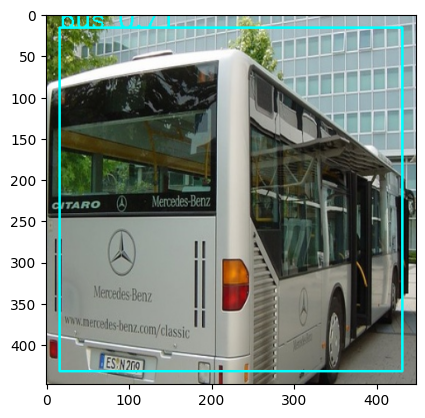

In [ ]:
random_img = np.random.choice(test_images)
img_path = os.path.join(DATA_FOLDER, TEST_IMG_DIR, random_img)

visualize_result(img_path)

## Conclusion

### Data Preprocessing & Augmentation

- The `albumenations` library is used to perform data augmentation. See the below code block for the data augmentation pipeline.
    - `HorizontalFlip`: Randomly flip the image horizontally.
    - `RandomGamma`: Randomly change the gamma (brightness) of the image.
    - `ShiftScaleRotate`: Randomly apply affine transformations: translate, scale and rotate the image.
    - `RandomBrightnessContrast`: Randomly change the brightness and contrast of the image.
    - `RGBShift`: Randomly shift the RGB channels of the image.
    - `RandomSizedBBoxSafeCrop`: Randomly crop the image and its bounding boxes.
    - `Resize`: Resize the image to the specified size.
    - `bbox_params`: Parameters for bounding boxes.
        - `min_area`: Minimum area of a bounding box to be considered.
        - `min_visibility`: Minimum visibility of a bounding box to be considered.
    - The augmented dataset is 10x larger than the original dataset.
    - Augmentation is done only once, and the augmented images along with their bounding boxes are written into disk for later use.
- Rest of the data preprocessing is basically the same as the given template code.


```python
aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomGamma(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.RGBShift(r_shift_limit=30, g_shift_limit=30, b_shift_limit=30, p=0.3),
    A.RandomSizedBBoxSafeCrop(IMAGE_SIZE, IMAGE_SIZE, p=0.5),
    A.Resize(IMAGE_SIZE, IMAGE_SIZE)
], bbox_params=A.BboxParams(format="pascal_voc", min_area=2000, min_visibility=0.2, label_fields=["class_labels"]))
```

### Building Model

- Feature extraction is done using a pre-trained `EfficientNetV2L` model.
    - `EfficientNet` is a family of models that have been designed to scale up in a more structured manner than simply increasing the depth, width, or resolution of the network.
        - Its basic building block is the `MBConv` block, which is a mobile inverted bottleneck convolution.
            - It consists of a depthwise convolution, a pointwise convolution, and a squeeze-and-excitation block.
            - The depthwise convolution reduces the number of parameters and computations.
            - The pointwise convolution increases the number of channels.
            - The squeeze-and-excitation block helps the model to focus on important features.
        - Rather than scaling up only one of depth, width, or resolution of the network, `EfficientNet` scales all three dimensions simultaneously.
            - The scaling coefficients $\alpha$ (depth), $\beta$ (width), and $\gamma$ (resolution) are determined by a grid search in a small scale.
            - Then, the scaling coefficients are then fixed and used to scale up the model to a larger scale.
            - A hyperparameter $\phi$ (compound scaling factor) is used to scale up the model.
                - Depth: $d = \alpha^\phi$
                - Width: $w = \beta^\phi$
                - Resolution: $r = \gamma^\phi$
                - Constraint: $d \cdot w^2 \cdot r^2 \approx 2^2$ and $\alpha \geq 1, \beta \geq 1, \gamma \geq 1$
            - Total FLOPS increases linearly with $(\alpha \cdot \beta^2 \cdot \gamma^2)^\phi$ with respect to $\phi$.
    - The model has ~100M parameters and is trained on the ImageNet dataset.
    - The weights of the model are **frozen during training**.
    - This is the best model affordable for us that is available in the `tf.keras.applications` module.
        - We've also tried `DenseNet`, `ResNet`, `VGG19`, and the vanilla YOLOv1 model. However, `EfficientNetV2L` performed the best.
        - We expect a higher capacity model (e.g. ViT) to perform better on this task.
- Several convolutional + leaky ReLU layers are appended after the feature extraction layers.
    - The initial weights of these layers are initialized with `TruncatedNormal(stddev=0.01)`.
        - The `stddev` parameter need to be **small enough**, or the model will struggle to converge. **(!)**
- The models outputs bounding boxes for:
    - **5x5** grid cells.
        - This is better than the **7x7** grid cells used in the template code.
    - 4 bounding boxes per grid cell.
    - 20 classes.


### Training

- Hardware
    - CPU : Intel(R) Xeon(R) Gold 6230 CPU @ 2.10GHz * 2
    - RAM: 196 GB
    - GPU: Tesla V100-PCIE-32GB * 2
- Training Time: 25 minutes/epoch, 60 epochs = ~25 hours
- Batch size: `32`
- Learning rate: `3e-5`
- Loss weights:
    - `OBJECT_SCALE = 1`
    - `NOOBJECT_SCALE = 0.5`
    - `CLASS_SCALE = 1`
    - `COORD_SCALE = 5`

### Process Output

- The given template only outputs a **single bounding box** with the highest confidence score for each image. However, an image may contain **multiple objects**.
    - We modified the output format to output all bounding boxes with **confidence scores higher than a certain threshold** (final: `0.001`).
    - The visualization of the output is also modified to show all bounding boxes.
    - For the above use cases, at least a specified number of bounding boxes should be output for each image (final: `1`).